<a href="https://colab.research.google.com/github/pandey2021/Stock-Price-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction


In [ ]:
## Steps to Proceed:
### Data Collection Part
### We will collect the Stock Data -- AAPL
### Create an stacked LSTM model
### Predict the test data and plot the output
### Predict the future 30 days and plot the output

In [ ]:
# Data Collection
import pandas_datareader as pdr

In [ ]:
df = pdr.get_data_tiingo('AAPL', api_key = '5abc7fb459d9bb267f1a95fb24cc7c35731a9128')

<ipython-input-3-76815e4d091a>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo('AAPL', api_key = '5abc7fb459d9bb267f1a95fb24cc7c35731a9128')


In [ ]:
df.to_csv('AAPL.csv')

In [ ]:
df.tail()

close    high     low    open    volume  \
symbol date                                                                  
AAPL   2023-10-30 00:00:00+00:00  170.29  171.17  168.87  169.02  51130955   
       2023-10-31 00:00:00+00:00  170.77  170.90  167.90  169.35  44846017   
       2023-11-01 00:00:00+00:00  173.97  174.23  170.12  171.00  56934906   
       2023-11-02 00:00:00+00:00  177.57  177.78  175.46  175.52  77334752   
       2023-11-03 00:00:00+00:00  176.65  176.82  173.35  174.24  79829246   

                                  adjClose  adjHigh  adjLow  adjOpen  \
symbol date                                                            
AAPL   2023-10-30 00:00:00+00:00    170.29   171.17  168.87   169.02   
       2023-10-31 00:00:00+00:00    170.77   170.90  167.90   169.35   
       2023-11-01 00:00:00+00:00    173.97   174.23  170.12   171.00   
       2023-11-02 00:00:00+00:00    177.57   177.78  175.46   175.52   
       2023-11-03 00:00:00+00:00    176.65   176.82  173.35   174.24   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2023-10-30 00:00:00+00:00   51130955      0.0          1.0  
       2023-10-31 00:00:00+00:00   44846017      0.0          1.0  
       2023-11-01 00:00:00+00:00   56934906      0.0          1.0  
       2023-11-02 00:00:00+00:00   77334752      0.0          1.0  
       2023-11-03 00:00:00+00:00   79829246      0.0          1.0

In [ ]:
df1 = df.reset_index()['close']

In [ ]:
df1.shape

(1256,)

In [ ]:
df1

0       209.95
1       208.49
2       204.47
3       194.17
4       192.23
         ...  
1251    170.29
1252    170.77
1253    173.97
1254    177.57
1255    176.65
Name: close, Length: 1256, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

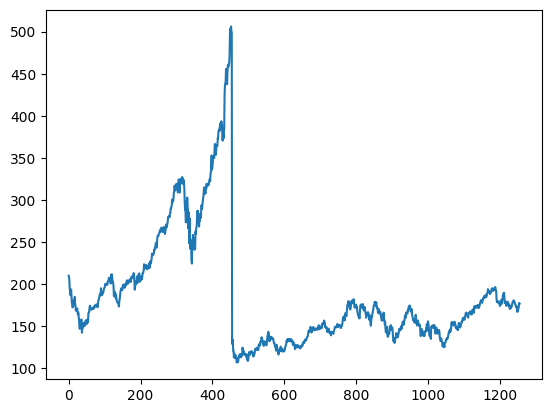

In [ ]:
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. So we apply MinMax Scaler
### Here closing price is the scale

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler
### Scaling down the feature between 0 & 1
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(1256, 1)

In [ ]:
### All values is between 0 and 1
df1


array([[0.25825924],
       [0.25460238],
       [0.2445335 ],
       ...,
       [0.16814026],
       [0.17715717],
       [0.17485285]])

In [ ]:
### In time series data is dependent on the previous data. so split it in 70:30 for train and test respectively

In [ ]:
### Splitting the dataset in train and test split
training_size= int(len(df1)*0.65)
test_size = int(len(df1) - training_size)
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [ ]:

len(train_data)

816

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, Y_train = create_dataset(train_data,time_step)
X_test, Y_test = create_dataset(test_data,time_step)

In [ ]:
print(X_train)


[[0.25825924 0.25460238 0.2445335  ... 0.21139637 0.21835942 0.22169067]
 [0.25460238 0.2445335  0.21873513 ... 0.21835942 0.22169067 0.22254227]
 [0.2445335  0.21873513 0.21387602 ... 0.22169067 0.22254227 0.22582342]
 ...
 [0.12090169 0.11829681 0.10552286 ... 0.1323732  0.13119599 0.15902317]
 [0.11829681 0.10552286 0.10697558 ... 0.13119599 0.15902317 0.17016907]
 [0.10552286 0.10697558 0.10339386 ... 0.15902317 0.17016907 0.16974327]]


In [ ]:
print(X_test.shape), print(Y_test.shape)

(339, 100)
(339,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
### create the stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 12s 430ms/step - loss: 0.0459 - val_loss: 0.0019
Epoch 2/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0155 - val_loss: 0.0047
Epoch 3/100
12/12 [==============================] - 4s 379ms/step - loss: 0.0134 - val_loss: 6.7490e-04
Epoch 4/100
12/12 [==============================] - 7s 590ms/step - loss: 0.0106 - val_loss: 3.1136e-04
Epoch 5/100
12/12 [==============================] - 5s 375ms/step - loss: 0.0109 - val_loss: 0.0020
Epoch 6/100
12/12 [==============================] - 4s 359ms/step - loss: 0.0087 - val_loss: 5.8678e-04
Epoch 7/100
12/12 [==============================] - 5s 440ms/step - loss: 0.0082 - val_loss: 2.7198e-04
Epoch 8/100
12/12 [==============================] - 4s 330ms/step - loss: 0.0068 - val_loss: 6.3417e-04
Epoch 9/100
12/12 [==============================] - 4s 298ms/step - loss: 0.0066 - val_loss: 7.8659e-04
Epoch 10/100
12/12 [==============================] - 6s 481ms/ste

In [ ]:
### lets do the prediction and check the performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 38ms/step


In [ ]:
### Transform back to the original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
### calculate RMSE performance matrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

0.03416254689079926

In [ ]:
math.sqrt(mean_squared_error(Y_test, test_predict))

0.013930322880835143

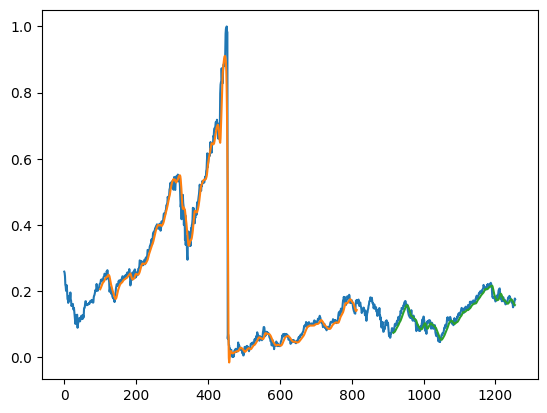

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

440

In [ ]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.15932365]
101
1 day input [0.19829681 0.19556669 0.19579211 0.19316218 0.20077646 0.19997495
 0.19644333 0.20343143 0.20641202 0.20726362 0.21823419 0.2144521
 0.21162179 0.21282405 0.20999374 0.20480902 0.20348153 0.20771446
 0.20964308 0.21001879 0.21828428 0.21763306 0.2210645  0.21613024
 0.21314966 0.21517846 0.21735755 0.21956168 0.21635567 0.22289292
 0.22444584 0.22232937 0.21475266 0.21122104 0.18822793 0.18036318
 0.18274264 0.17871008 0.17815905 0.1777082  0.18189105 0.17685661
 0.17465247 0.1682154  0.16944271 0.17282405 0.17630557 0.18604884
 0.17417658 0.17976205 0.18371947 0.19356293 0.20240451 0.20295554
 0.20693801 0.20753914 0.19053225 0.17713212 0.17868503 0.18164058
 0.17397621 0.16874139 0.17257358 0.17074515 0.17815905 0.18091421
 0.1719474  0.16804008 0.17019411 0.17342517 0.16310582 0.15927364
 0.15992486 0.1612273  0.16758923 0.16420789 0.16736381 0.17049468
 0.17695679 0.18071384 0.17921102 0.18274264 0.18502192 0.18036318
 0.18003757 0.1761052  0.17282405 

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt
len(df1)

1256

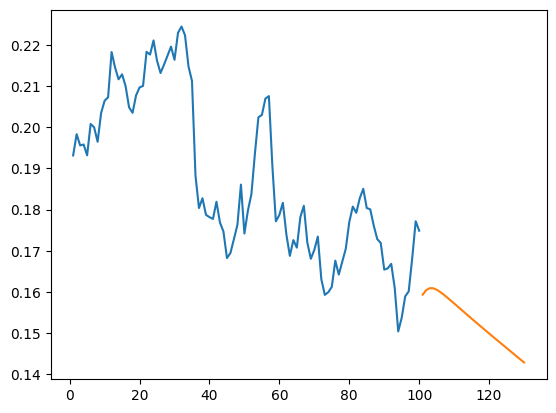

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1156:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

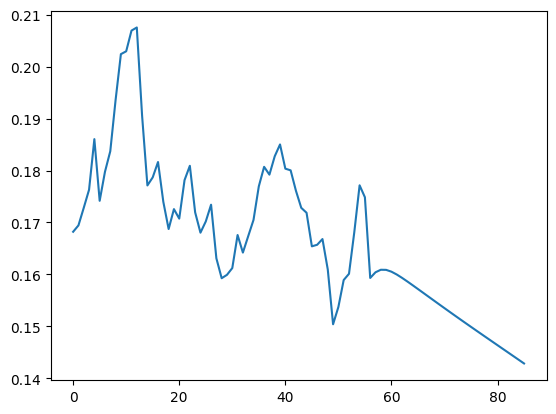

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

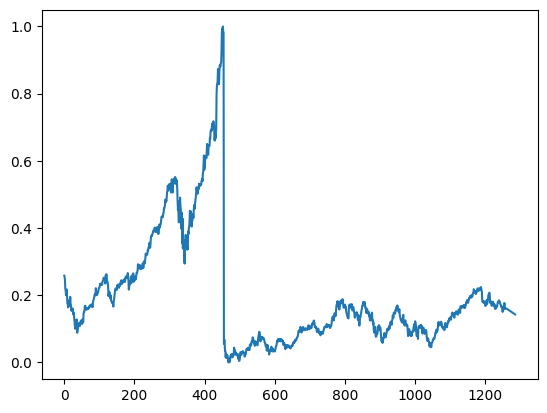

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)